# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
df=pd.read_csv('/datasets/autos.csv')


In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Выбросы и пропуски

In [6]:
df['NumberOfPictures'].unique()

array([0])

Хороший магазин, и машиные красивые. Ничего что нет ни одной фотографии

In [7]:
df=df.drop('NumberOfPictures',axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [9]:
cat_col=list(df.select_dtypes(include=object).columns)
num_col=list(df.select_dtypes(exclude=object).columns)

<AxesSubplot:>

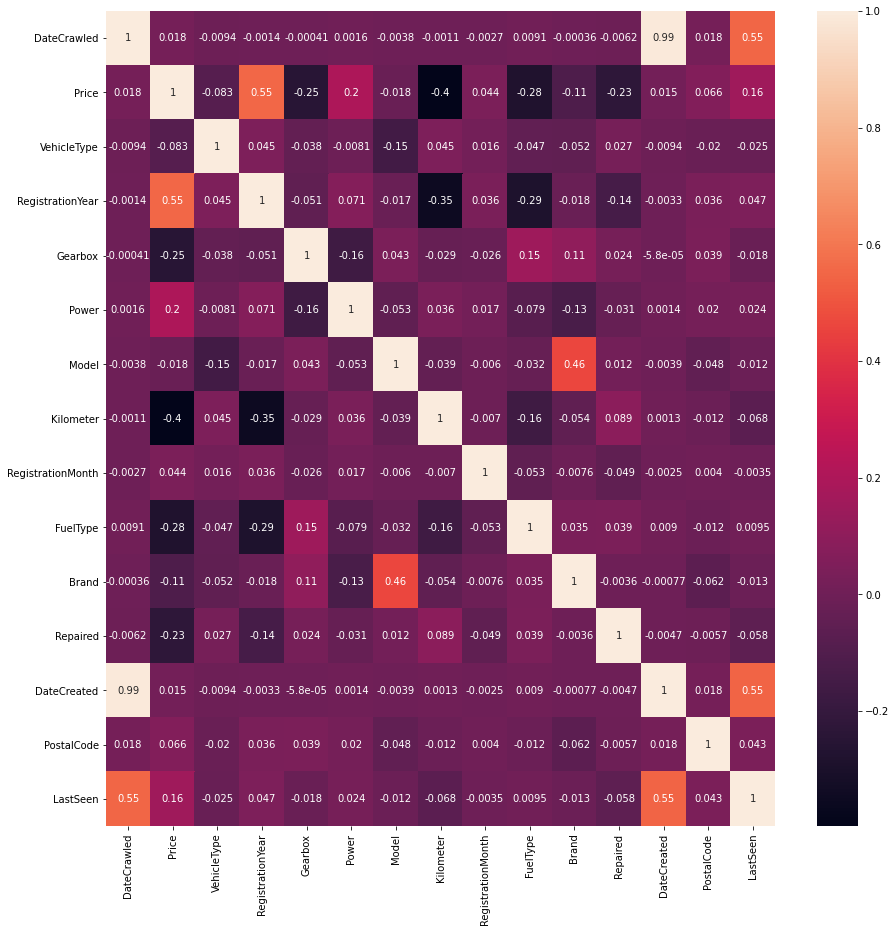

In [10]:
enc_df=df.copy().dropna()
enc=OrdinalEncoder().fit_transform(df[cat_col].dropna())
enc_df[cat_col]=enc
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pd.DataFrame(enc_df,columns=df.columns).corr(),annot=True)

DateCreated и DateCrawled  зависят друг от друга напряму, анкету создают и скачивают в полдннь, не думаю что это несет ценность, вохможно стоит удалить один из столбцов, или даже оба- как дата публикации объявления влияет на цену? Никак, тогда и lastseen. Ну наверное почтый индекс тоже не несет нагрузки.

In [11]:
df=df.drop(['DateCreated','DateCrawled','LastSeen','PostalCode'],axis=1)

In [12]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

In [13]:
df.groupby(by=['Model']).agg(
        pd.Series.mode)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Model,,,,,,,,,,
100,0,sedan,1991,manual,150,150000,0,petrol,audi,no
145,250,small,2000,manual,103,150000,0,petrol,alfa_romeo,no
147,1500,sedan,2001,manual,105,150000,3,petrol,alfa_romeo,no
156,0,wagon,2001,manual,155,150000,0,petrol,alfa_romeo,no
159,5500,wagon,2006,manual,150,150000,5,gasoline,alfa_romeo,no
...,...,...,...,...,...,...,...,...,...,...
yaris,2500,small,2001,manual,69,150000,3,petrol,toyota,no
yeti,12900,suv,2011,manual,105,70000,3,petrol,skoda,no
ypsilon,500,small,2000,manual,60,150000,3,petrol,lancia,no


In [14]:
df.groupby(by=['Brand']).agg(
        pd.Series.mode)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Repaired
Brand,,,,,,,,,,
alfa_romeo,0,sedan,2001,manual,150,156,150000,0,petrol,no
audi,0,wagon,2006,manual,0,a4,150000,3,petrol,no
bmw,0,sedan,2005,manual,150,3er,150000,6,petrol,no
chevrolet,0,small,2007,manual,0,other,150000,7,petrol,no
chrysler,0,bus,2000,auto,0,other,150000,0,petrol,no
citroen,0,small,2005,manual,0,other,150000,3,petrol,no
dacia,2500,wagon,2009,manual,75,logan,150000,"[3, 6]",petrol,no
daewoo,300,small,2004,manual,0,matiz,150000,3,petrol,no
daihatsu,0,small,2000,manual,0,cuore,150000,0,petrol,no


Итак, мы имеем пропуски, и пропуски в категориальных признаках. В целом их можно заменить как можно более точно, но для этого нужно закодировать в численные значения, и через группировку выбирать медианные значения. Но так как тут можно поймать ошибку, и на мой взгляд можно решить проще, я сделаю проще.


Заполню модель машины по моде среди бренда.

In [15]:
df[df['Brand']=='sonstige_autos']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
306,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no
650,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no
661,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...,...
354062,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no
354073,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes


In [16]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Я выявил проблему, что у бренда sonstige_autos вообще не известны модели.

In [17]:
df.loc[df['Brand']=='sonstige_autos','Model']=df.loc[df['Brand']=='sonstige_autos','Model'].fillna('sonstige_autos')

Заполнил модели брендом

Теперь заполним пропуски в моделях-модой по бренду

In [18]:
group_model = df.groupby(by=['Brand']).agg(pd.Series.mode)['Model'] #Столбец из агрегации моды групировки ДФ по модели
for i in df[df['Model'].isna() == True].index:
    df.loc[i, 'Model'] = group_model[df.loc[i, 'Brand']]

Заполню пропуски для коробки передач модой по модели машины. Неизвестные модели машины заполню other

In [19]:
group_gear = df.groupby(by=['Model']).agg(pd.Series.mode)['Gearbox'] #Столбец из агрегации моды групировки ДФ по модели
for i in df[df['Gearbox'].isna() == True].index:
    df.loc[i, 'Gearbox'] = group_gear[df.loc[i, 'Model']]

И заполним тип топлива yf petrol

In [20]:
df.loc[df['FuelType'].isna() == True,'FuelType']=df.loc[df['FuelType'].isna() == True,'FuelType'].fillna('petrol')

In [21]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             71154
dtype: int64

Часть пропусков заполнили. 

In [22]:
df.loc[df['Repaired'].isna() == True,'Repaired']=df.loc[df['Repaired'].isna() == True,'Repaired'].fillna('unknown')

Пропуски по типу кузова заполню по моде бренда

In [23]:
group_type = df.groupby(by=['Brand']).agg(pd.Series.mode)['VehicleType'] #Столбец из агрегации моды групировки ДФ по модели
for i in df[df['VehicleType'].isna() == True].index:
    df.loc[i, 'VehicleType'] = group_type[df.loc[i, 'Brand']]

In [24]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

Пропусков нет. Обновлю колонки категорий.

In [25]:
cat_col=list(df.select_dtypes(include=object).columns)
num_col=list(df.select_dtypes(exclude=object).columns)

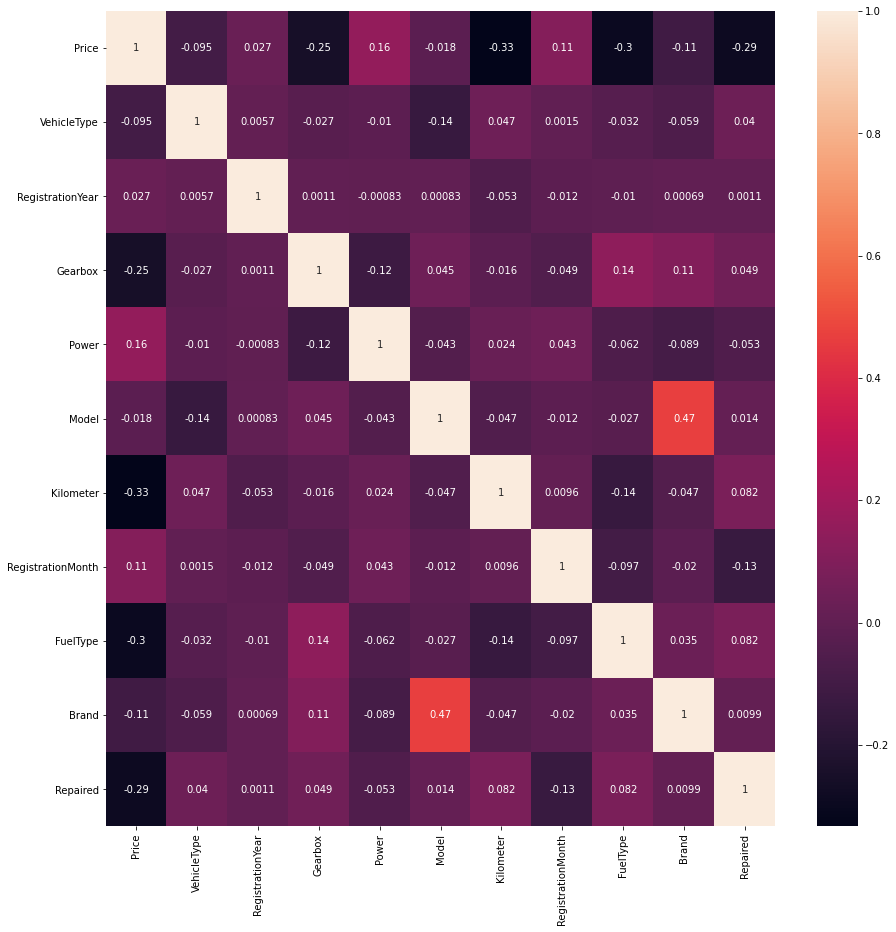

In [26]:
enc_df=df.copy()
enc=OrdinalEncoder().fit_transform(df[cat_col])
enc_df[cat_col]=enc
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pd.DataFrame(enc_df,columns=df.columns).corr(),annot=True);

In [27]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Что-то не так с годом регистрации ТС. Есть выбросы до 1000 года и до 9999. удалю значения до 1900 и больше 2023, и уберем машины с выбросами по мощности

<AxesSubplot:>

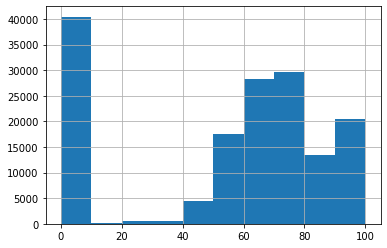

In [28]:
df['Power'].hist(range=(0,100))

In [29]:
df=df[(df['RegistrationYear']>1900)&(df['RegistrationYear']<=2016)]
df=df[(df['Power']>=40)&(df['Power']<1000)]

In [30]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,301658.000000,301658.000000,301658.000000,301658.0000,301658.000000
mean,4757.516326,2002.820224,121.078228,128585.6997,5.967682
std,4618.835326,6.436883,54.618951,36617.8313,3.598434
min,0.000000,1910.000000,40.000000,5000.0000,0.000000
25%,1250.000000,1999.000000,77.000000,125000.0000,3.000000
50%,3000.000000,2003.000000,112.000000,150000.0000,6.000000
75%,6900.000000,2007.000000,150.000000,150000.0000,9.000000
max,20000.000000,2016.000000,999.000000,150000.0000,12.000000


Цена 0 - вот это удача, берем...и удаляем эти выбросы) Не ну а что, это целевой признак, мне и так кажется можно было бы удалить все NaNы и не париться 3 часа. Если мы сейчас начнем цену забивать медиаными и тд, мне кажется у нас все поплывет по предсказаниям.

<AxesSubplot:>

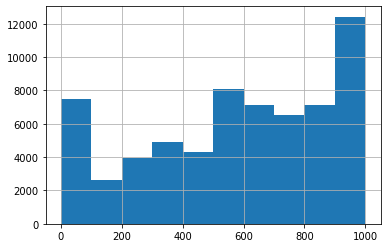

In [31]:
df['Price'].hist(range=(0,1000))

In [32]:
df=df[(df['Price']>500)]

<AxesSubplot:>

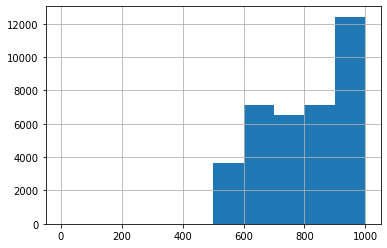

In [33]:
df['Price'].hist(range=(0,1000))

Цены в евро, за 500 евро можно купить машину? Не сегодня) Ну ладно мы купим

In [34]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,273945.000000,273945.000000,273945.000000,273945.000000,273945.000000
mean,5212.883645,2003.225250,124.037884,127681.158627,6.084535
std,4607.727139,6.295533,54.432284,36865.798972,3.545331
min,501.000000,1910.000000,40.000000,5000.000000,0.000000
25%,1600.000000,2000.000000,84.000000,125000.000000,3.000000
50%,3500.000000,2004.000000,116.000000,150000.000000,6.000000
75%,7499.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,999.000000,150000.000000,12.000000


Ну вроде теперь все выглядит вменяемо

### Подготовка выборок к обучению

In [35]:
cat_col=list(df.select_dtypes(include=object).columns)
num_col=list(df.select_dtypes(exclude=object).columns)

In [36]:
X=df.drop('Price',axis=1)
y=df['Price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
X_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
262220,wagon,2006,manual,174,transporter,150000,5,gasoline,volkswagen,no
168509,sedan,2000,manual,50,polo,150000,10,petrol,volkswagen,unknown
315105,coupe,1999,manual,179,tt,150000,4,petrol,audi,no
157800,small,2010,manual,105,ibiza,125000,4,gasoline,seat,no
200359,sedan,2004,manual,101,golf,150000,4,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
155089,bus,2005,manual,125,zafira,150000,1,petrol,opel,no
335159,wagon,1997,manual,101,a4,150000,9,petrol,audi,unknown
170657,wagon,1995,auto,150,e_klasse,150000,7,petrol,mercedes_benz,unknown
189989,bus,2003,manual,116,touran,150000,12,petrol,volkswagen,no


Вывод: В ходе предобработки данных были убраны пропуски в значениях, и странные выбросы по данным.

## Обучение моделей

### Решающее дерево

In [39]:
enc_X_train=X_train.copy()
enc_tr=OrdinalEncoder().fit_transform(X_train[cat_col])
enc_X_train[cat_col]=enc_tr

enc_X_test=X_test.copy()
enc_test=OrdinalEncoder().fit_transform(X_test[cat_col])
enc_X_test[cat_col]=enc_test

In [40]:
%%time
model = DecisionTreeRegressor(random_state=12345)
model.fit(enc_X_train, y_train)
predictions_train_oe = model.predict(enc_X_test)
rmse = mean_squared_error(y_test, predictions_train_oe)**0.5
print('RMSE для решающего дерева:', rmse)

RMSE для решающего дерева: 2083.1619904210334
CPU times: user 834 ms, sys: 16 ms, total: 850 ms
Wall time: 855 ms


In [41]:
%%time
param_grid2 = {'min_samples_leaf': range(1, 20, 1),
              'min_samples_split':range(2, 20, 1),
              'max_depth':range(1, 20,1)
             }

grd2 = RandomizedSearchCV(DecisionTreeRegressor(random_state=12345), param_distributions=param_grid2,cv=5, scoring='neg_root_mean_squared_error', n_jobs=4,random_state=42)
grd2.fit(enc_X_train, y_train)
display(grd2.best_params_)
display(grd2.best_score_*-1)

{'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 19}

1796.3309009532309

CPU times: user 867 ms, sys: 288 ms, total: 1.15 s
Wall time: 33.3 s


Получили rmse 1831, меньше 2500 по заданию, посмотрим что даст бустинг.

### LightGBM

Нужно привести кат признаки к типо category

In [42]:
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object':
        X_train[c] = X_train[c].astype('category')
        
for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object':
        X_test[c] = X_test[c].astype('category')

/tmp/ipykernel_245/3865537407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype('category')
/tmp/ipykernel_245/3865537407.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[c] = X_test[c].astype('category')


In [43]:
model = lgb.LGBMRegressor(random_state=12345)
model.fit(X_train, y_train)
predictions_train = model.predict(X_test)


In [44]:
rmse = mean_squared_error(y_test, predictions_train)**0.5
print(rmse)

1606.3942178172485


Подберу параметры

In [45]:
#{'num_leaves': 190, 'n_estimators': 500, 'learning_rate': 0.05}
"""model = lgb.LGBMRegressor(random_state=12345)
param_grid = {'n_estimators': range(480, 520, 10),
              'num_leaves':range(170, 200,10),
              'learning_rate':[0.05,0.01,0.001]
             }
grd = RandomizedSearchCV(model, param_distributions=param_grid,cv=5, scoring='neg_root_mean_squared_error', n_jobs=4,random_state=42)
grd.fit(X_train, y_train)
display(grd.best_params_)
display(grd.best_score_*-1)"""



"model = lgb.LGBMRegressor(random_state=12345)\nparam_grid = {'n_estimators': range(480, 520, 10),\n              'num_leaves':range(170, 200,10),\n              'learning_rate':[0.05,0.01,0.001]\n             }\ngrd = RandomizedSearchCV(model, param_distributions=param_grid,cv=5, scoring='neg_root_mean_squared_error', n_jobs=4,random_state=42)\ngrd.fit(X_train, y_train)\ndisplay(grd.best_params_)\ndisplay(grd.best_score_*-1)"

Вывод: после обучения моделей по перебору 3 гипперпараметров получены результаты качетсва моделей 1531 LightGBM и 1618 Решающего дерева.
П.С. Могу сделать предположение, что решающее дерево может обучаться дольше или на равне с ГБ, так как тоже имеет гиппер параметр "Количество решателей", что увеличивает время решения.

## Анализ моделей

### LGBM

Обучение модели

In [52]:
%%time
model1 = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=190,
                         learning_rate=0.05)
model1.fit(X_train, y_train)

CPU times: user 5min 3s, sys: 3.27 s, total: 5min 6s
Wall time: 5min 8s


LGBMRegressor(learning_rate=0.05, n_estimators=500, num_leaves=190,
              random_state=12345)

Время предсказания модели

In [47]:
%%time 
predictions_test = model.predict(X_train)
rmse = mean_squared_error(y_train, predictions_test)**0.5
print(rmse)

1549.293744585325
CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.89 s


### DecisionTreeRegressor

#{'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 19}

Время обучения модели

In [48]:
%%time
model2 = DecisionTreeRegressor(random_state=12345,
                          min_samples_split=3,
                          min_samples_leaf=7,
                         max_depth=19)
model2.fit(enc_X_train, y_train)

CPU times: user 575 ms, sys: 0 ns, total: 575 ms
Wall time: 624 ms


DecisionTreeRegressor(max_depth=19, min_samples_leaf=7, min_samples_split=3,
                      random_state=12345)

Время предсказания модели

In [49]:
%%time 
predictions_test2 = model2.predict(enc_X_train)
rmse2 = mean_squared_error(y_train, predictions_test2)**0.5
print(rmse2)

1398.8371411827652
CPU times: user 49.5 ms, sys: 1.14 ms, total: 50.6 ms
Wall time: 57.9 ms


In [56]:
tabledata = [
         ["Решающее дерево: обучение", "575 ms", "624 ms",' '],
         ["Решающее дерево: предсказание", "49,5 ms", "57,9 ms",'1832'],
         ["LightGBM: обучение", "5min", "5 min",' '],
         ["LightGBM: предсказание", "1,87 s", "1,87 s",'1496']]
dfr= pd.DataFrame(tabledata, columns=["модель","CPU-times", "Wall time",'RMSE Результат'])
dfr = dfr.set_index('модель')
dfr.index.names = [None]
dfr

,CPU-times,Wall time,RMSE Результат
Решающее дерево: обучение,575 ms,624 ms,
Решающее дерево: предсказание,"49,5 ms","57,9 ms",1832
LightGBM: обучение,5min,5 min,
LightGBM: предсказание,"1,87 s","1,87 s",1496


Вывод: по сводной таблице видно, что модель градиентного бустинга обучается намного дольше чем решающее дерево. Однако время предсказания у ГБ больше всего в 3 раза, а результат по RMSE значительно выше.
По данным анализа и условий ТЗ рекоммендую заказчику модель LightLGM. Проведем ее тестирование.

## Тестирование лучшей модели

Поскольку в ТЗ было в первую очередь важно качество предсказаний, то я считаю что рационально сделать рекомендацию по применениею  LightLGM. В конце концов в бизнесе лучше не торопиться с выводами, особенно если они быстрые и ошибочные.

Выполню предикт по тестовой выборке

In [53]:
%%time 
predictions_test = model1.predict(X_test)
rmse = mean_squared_error(y_test, predictions_test)**0.5
print(rmse)

1496.207535330627
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.5 s


## Вывод

На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий. Удалили дубликаты.

 Для модели решающего дерева применили порядковое кодирование, в итоге количесвто столбцов не изменилось, а подбор гиперпараметров стал быстрее. Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами {'num_leaves': 190, 'n_estimators': 500, 'learning_rate': 0.05} дает наименьшее значение rmse: 1496.

Мы проанализировали все модели и обнаружили, что дольше всего учится модель LightGBM, но имеет наилучшие показания качества модели по RMSE 1495 против 1832 у Решающего дерева.

Исходя из требований заказчика по скорости обучения, придсказания и качества модели, рекомендуем модель LightGBM, поскольку она имеет самые оптимальные характеристики. Так как в данном случае мы имеем недостаток только в скорости обучения, однако по сути это одноразовая процедура, а предсказания имеют переодический характер, и на мой взгляд на длинной дистанции предсказаний мы будем выигрывать по времени. А выйгрыш по качеству модели доказывает эффективность модели градиентного бустинга.